## Overview of Exploratory Data Analysis: Differential Features (Clay Court Version)

In the previous step (see Workbook 2: Feature_Development), a relatively large number (~150) of features were created out of the cleaned raw data (see Workbook 1: Data_Cleaning_Wrangling). In this step, correlation heat mapping and scatterplots are constructed to provide an intuitive feel for the relationship between individual features and the target feature (% points won by a given player in a given match to be predicted on using features derived from performance prior to the match being predicted on); see Intro to Workbook 2, and commented body of that workbook, for more details on what is exactly meant by this.

This EDA workbook has also been heavily used to shape adaptations/expansions/deletions of features developed in the prior stage.

Note that this workbook is conducted separately for hard court and clay court performance. In the first two stages of the project, hard and clay court performance are run together (though most features are computed with respect to surface; see Workbook 2 for details). But from this stage forward, including pre-modeling and modeling, hard court and clay court data are considered separately. This is a result of modeling efforts showing significant differences both in prediction quality and feature importance for the two surfaces. More to say about that in later notebooks. This is the clay court version.  

Currently, data (on a surface-specific basis) from years 2012-2019 are used in EDA/modeling for clay court matches (2015-2019 for the larger sample size/year hard court match sample), with an additional 3 years prior to that used for retrospective feature accrual (2009-2011 for clay court matches, 2012-2014 for hard court matches). Also, a threshold of minimum of 20 prior matches for BOTH players in a given match to be predicted on is employed. Not surprisingly, prediction accuracy is sensitive to the amount of data available to generate predictive features, as well as to the amount of data available to train and test the model. Critically, matches filtered out at the current point and beyond (ie, during modeling) WERE used for feature generation.
    * As an additional data inclusion reminder, matches played on grass (too low a sample size; also removed Davis up and Olympics matches for same reason as well as for their "odd" contexts) and matches where one player withdrew (usually for injury reason) either before the match or early on in the match were filtered out and NOT included in feature generation. Critically, matches filtered out at this point WERE used for feature generation. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [26]:
df = pd.read_csv('../data/df_player_all_2009to2019.csv')

### Summaries of Data

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50356 entries, 0 to 50355
Columns: 160 entries, p_pts_won% to m_outcome
dtypes: float64(138), int64(16), object(6)
memory usage: 61.5+ MB


In [28]:
df.head()

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_id,t_date,tour_wk,...,p_tot_pts_last_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_matches_surf_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,p_H2H_pts_won%_diff,m_outcome
0,47.84,56.28,38.41,1.09,3.66,55.00,43.75,2019-560,20190826,2019_24,...,-0.0,-0.0,-0.0,-243.0,-109.0,179.240506,134.430380,-0.0,NaN,0
1,41.29,49.40,31.94,4.82,15.28,33.33,40.00,2019-M014,20191014,2019_29,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,NaN,0
2,37.23,51.85,17.50,3.70,5.00,33.33,0.00,2019-M004,20190225,2019_07,...,-0.0,-0.0,-0.0,-25.0,-24.0,133.805310,100.353982,-0.0,NaN,0
3,59.14,69.23,46.34,3.85,4.88,100.00,37.50,2019-7696,20191105,2019_33,...,9.0,49.0,46.9,-79.0,-77.0,109.423559,90.917141,0.0,NaN,1
4,53.66,70.77,34.48,7.69,3.45,88.89,37.50,2019-7696,20191105,2019_33,...,53.0,44.0,42.5,-17.0,-20.0,55.064126,48.178912,0.0,NaN,1


In [29]:
df.describe()

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_date,t_surf,t_indoor,...,p_tot_pts_last_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_matches_surf_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,p_H2H_pts_won%_diff,m_outcome
count,50356.000000,50356.000000,50356.000000,50356.000000,50356.000000,50356.000000,50356.000000,5.035600e+04,50356.000000,50356.000000,...,50356.000000,50356.000000,5.035600e+04,50356.000000,50356.000000,5.035600e+04,5.035600e+04,50356.000000,1.657200e+04,50356.000000
mean,50.000000,63.300279,36.699721,7.605990,7.605990,60.225233,39.774767,2.014017e+07,1.649337,0.198824,...,0.000000,0.000000,4.270368e-15,0.000000,0.000000,1.318644e-14,-3.254364e-14,0.000000,1.002229e-16,0.500000
std,6.651716,9.007659,9.007659,6.048368,6.048368,26.078600,26.078600,3.171815e+04,0.477182,0.399120,...,58.239384,80.752125,7.546307e+01,150.138308,97.527307,6.738746e+01,5.626222e+01,1.052471,1.164518e+01,0.500005
min,20.970000,21.880000,3.030000,0.000000,0.000000,0.000000,0.000000,2.009010e+07,1.000000,0.000000,...,-358.000000,-717.000000,-4.953000e+02,-499.000000,-501.000000,-5.175178e+02,-4.772915e+02,-17.000000,-4.648000e+01,0.000000
25%,45.310000,57.450000,30.650000,3.260000,3.260000,45.450000,23.530000,2.011081e+07,1.000000,0.000000,...,-8.000000,-13.000000,-1.200000e+01,-69.000000,-42.000000,-3.048839e+01,-2.546763e+01,0.000000,-8.220000e+00,0.000000
50%,50.000000,63.490000,36.510000,6.250000,6.250000,60.000000,40.000000,2.014050e+07,2.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.500000
75%,54.690000,69.350000,42.550000,10.470000,10.470000,76.470000,54.550000,2.017023e+07,2.000000,0.000000,...,8.000000,13.000000,1.200000e+01,69.000000,42.000000,3.048839e+01,2.546763e+01,0.000000,8.220000e+00,1.000000
max,79.030000,96.970000,78.120000,50.000000,50.000000,100.000000,100.000000,2.019111e+07,2.000000,1.000000,...,358.000000,717.000000,4.953000e+02,499.000000,501.000000,5.175178e+02,4.772915e+02,17.000000,4.648000e+01,1.000000


### Filter Data 

Currently, data (on a surface-specific basis) from years 2015-2019 are used in EDA/modeling, with an additional 3 years prior to that used for retrospective feature accrual. Also, a threshold of minimum of 20 prior matches for BOTH players in a given match to be predicted on is employed. Not surprisingly, prediction accuracy is sensitive to the amount of data available to generate predictive features, as well as to the amount of data available to train and test the model.

In [30]:
df_filter = df[~df['tour_wk'].str.contains("2009")] 
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2010")]
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2011")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2012")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2013")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2014")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2015")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2016")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2017")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2018")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2019")]

In [31]:
# Filter down to only matches played on clay courts 
df_filter2 = df_filter.loc[(df_filter["t_surf"] == 1)]
#df_filter2 = df_filter.loc[(df_filter["t_surf"] == 1) & (df_filter["p_matches_surf"] > 50)]

In [32]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted on. 
df_low = df_filter2.loc[df_filter2['p_matches_surf'] <= 20, 'm_num']
df_filter3 = df_filter2[~df_filter2['m_num'].isin(df_low)]

In [33]:
df_filter3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7214 entries, 304 to 50300
Columns: 160 entries, p_pts_won% to m_outcome
dtypes: float64(138), int64(16), object(6)
memory usage: 8.9+ MB


In [34]:
df_filter3["p_matches"].min()

22.0

In [35]:
df_filter_diff = df_filter3[["p_pts_won%", "high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", "p_sv_pts_won%_std_l60_decay_diff", "p_ret_pts_won%_std_l60_decay_diff", "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"]]

## Data Visualization

### Ranking, Court Conditions and Matchup-Specific Correlations to % Points Won Per-Player Per-Match

In [36]:
df_filter_diff_1 = df_filter3[["p_pts_won%", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_H2H_diff", "p_H2H_pts_won%_diff", "high_t_ace_p_ace", "high_t_ace_p_aced"]]

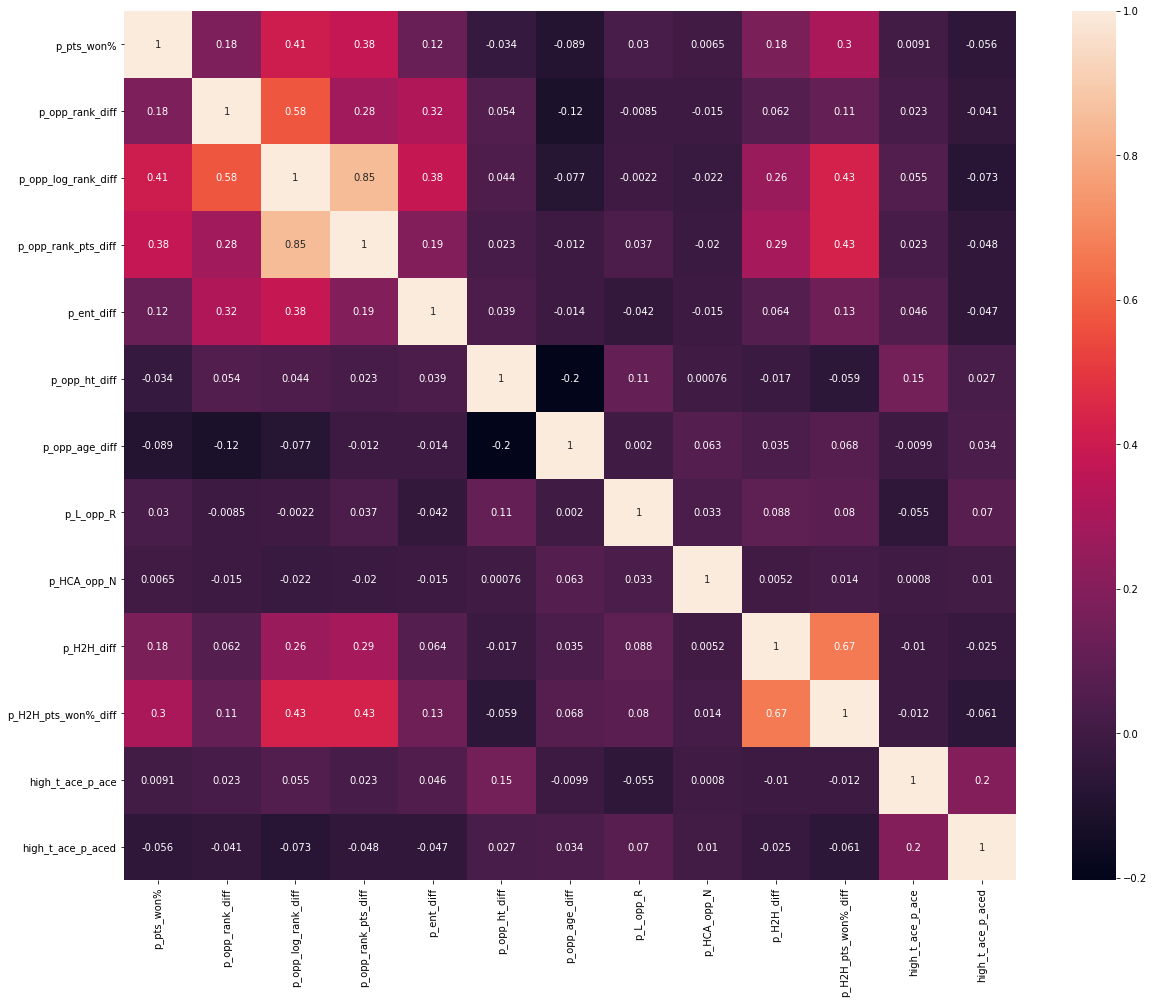

In [37]:
#Heatmap of correlations for pts_won% vs "differential features"
plt.subplots(figsize=(20,16))
sns.heatmap(df_filter_diff_1.corr(), annot = True);

Key Observations:
* The highest positive correlation (0.41) to target in this set of features is for the log of the difference in rankings between the two players in a match to be predicted on. This correlation is much stronger than that seen for ranking difference itself (0.18) and also stronger than that for ranking points difference. This makes intutive sense because the underlying skill difference between two players ranked close to the top of the rankings is surely greater than that for two players ranked far away from number 1 separated by the same raw difference in ranking spots (eg, rank 1 vs 10 and rank 1000 vs 1010).
* Past Head-to-Head performance differential between two players has a fairly strong positive correlation to target (.18 for match wins differential and .30 for % points won in past matches). These strengths are perhaps a bit surprising considering there are relatively few surface-specific matches in the sample for any pair of opponents in a given match to be predicted on.
* There's a modest (.12) positive correlation between entry type ("p_ent") and performance in a match to be predicted on. Perhaps not surprising given that players with direct entry tend to have higher rankings than those needing to qualify or needing a wild card/special exemption to gain entry. Also, qualifiers (and "lucky losers") can be presumed to have some degree of fatigue before their first main draw match (though they are also somewhat adapted to the conditions by then...).

### Past Performance Stats-Related Correlations to % Points Won Per-Player Per-Match (Non Ace-Aced)

In [38]:
#df_filter_diff_2 = df_filter3[["p_pts_won%", "p_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", "p_sv_pts_won%_std_l60_decay_diff", "p_ret_pts_won%_std_l60_decay_diff"]]
df_filter_diff_2 = df_filter3[["p_pts_won%", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_SOS_adj_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", "p_sv_pts_won%_std_l60_decay_diff", "p_ret_pts_won%_std_l60_decay_diff"]]

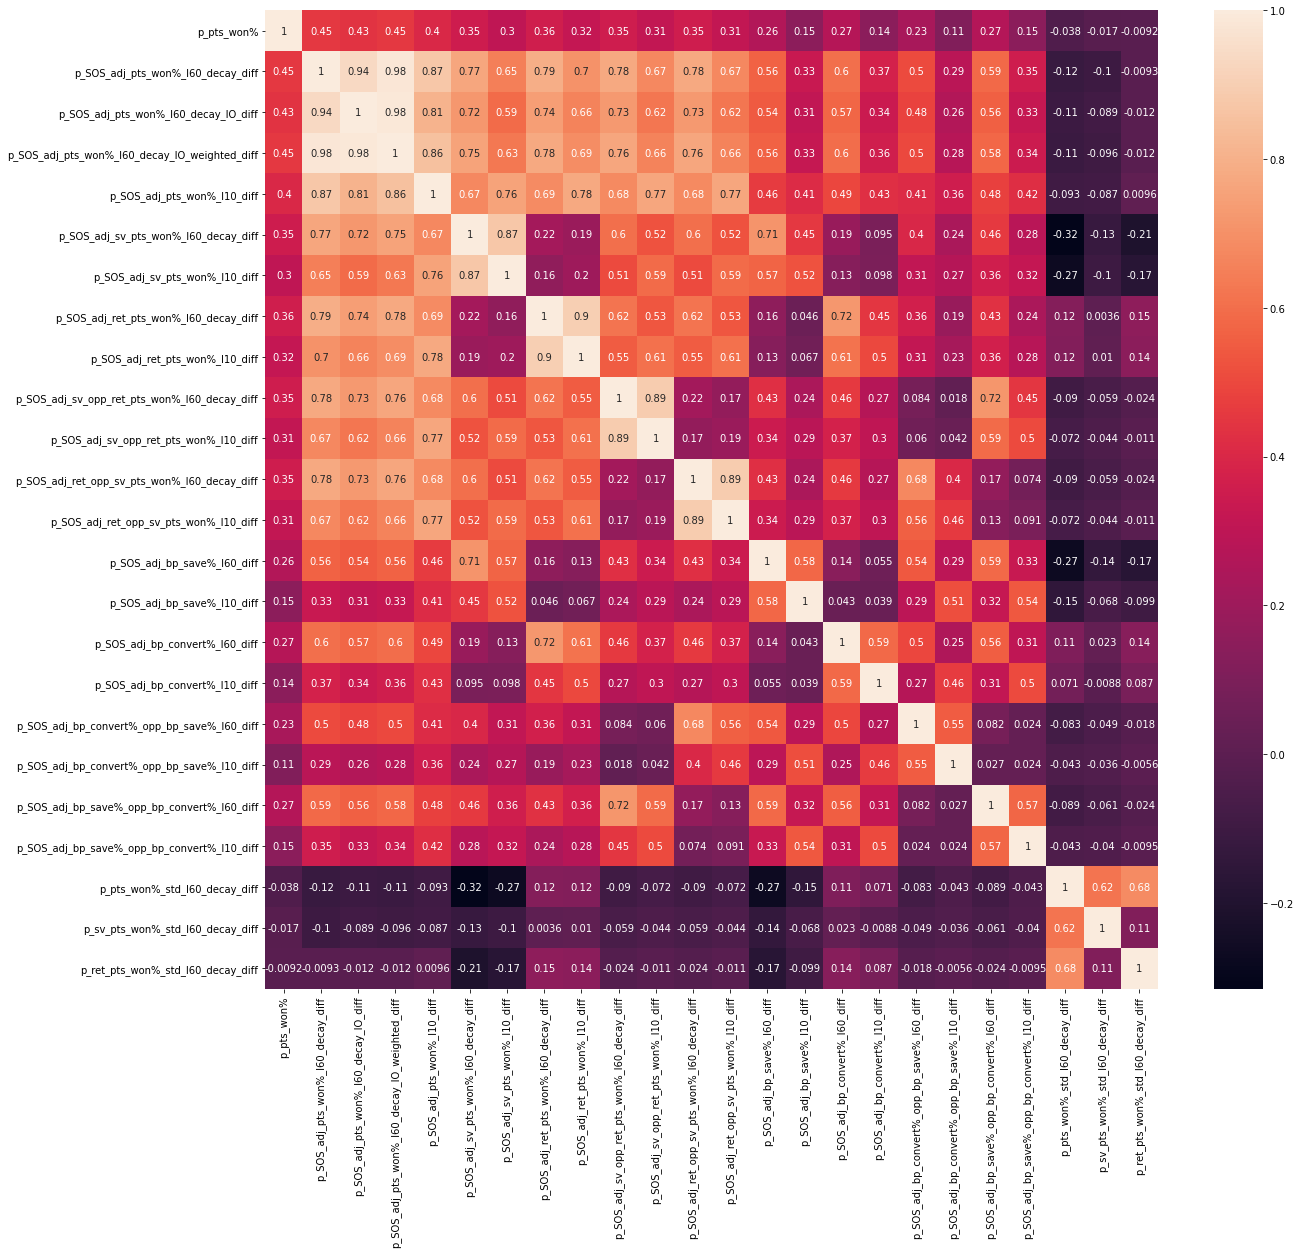

In [39]:
#Heatmap of correlations for pts_won% vs "differential features"
plt.subplots(figsize=(20,18))
sns.heatmap(df_filter_diff_2.corr(), annot = True);

Key Observations:
* The strongest positive correlation to target (0.45), both in this feature set and across all predictive features, is for strength of schedule adjusted, time decay-weighted total points won% over the past 60 surface-specific matches relative to that of their opponent in the match to be predicted on (ie, the differential version of the feature).
* A version on the above in which indoor vs outdoor status of past matches is considered and weighted against overall hard court performance over the last 60 matches has an equally high correlation, but a version where ONLY matches matching the indoor-outdoor status of the match to be predicted on ("p_SOS_adj_pts_won%_l60_decay_IO_diff") are used to compute past performance doesn't have as strong a correlation (0.43). This is likely because better condition matching to the match being predicted on is somewhat offset by the lower n's in past matches per condition subset and how relatively "smeared out" in time these matches would necessarily be. 
* SOS-adjusted (but not decay weighted) performance over just the last 10 surface-specific matches has a relatively high positive correlation to target (.40), though not as strong as the SOS-adjusted and decay-weighted version over the previous 60 surface specific matches. This short-term correlation is MUCH stronger with SOS-adjustment than without (not shown), which makes intuitive sense as over longer stretches of matches opponent strength tends to average out, but over shorter stretches opponent strength can be extremely non-uniform across players.
* A lot of these features focus on adjusted serving-specific ("offense") or return-specific ("defense") performance over the past 60 surface-specific matches. They mostly have solidly positive correlations with the target feature, but not as strong as when considering adjusted OVERALL past performance. 
    * Break point saved and converted features can be seen as "clutch performance" versions of serve and return past performance. These qualitatively track with aggregate serve and return performance correlations, though quantitatively lower most likely due to much lower unerlying sample size. Still, there certainly could be independent, predictive signal in "clutch" performance that makes it worth keeping these feature around for the modeling stages.
* It's interesting to note that adjusted return performance over the previous 60 matches has a slightly higher positive correlation (.36) with the target feature than adjusted serve performance (.35). On hard courts, the correlation for each to target is equal (both 0.33; see hard court version of this workbook). Returning prowess may be relatively more important to serving prowess on clay, whih makes intuitive sense given the slowness of the surface relative to hard courts.  
* The non-strength of schedule-adjusted versions of these features uniformly yield lower correlations (as do non-decay weighted versions). These correlations are not shown presently for the sake of visual clarity but have been explored extensively and used to shape changes to underlying functions used to generate the "optimized" feature versions.


### Past Performance Stats-Related Correlations to % Points Won Per-Player Per-Match (Ace-Aced)

In [40]:
df_filter_diff_3 = df_filter3[["p_pts_won%", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff"]]

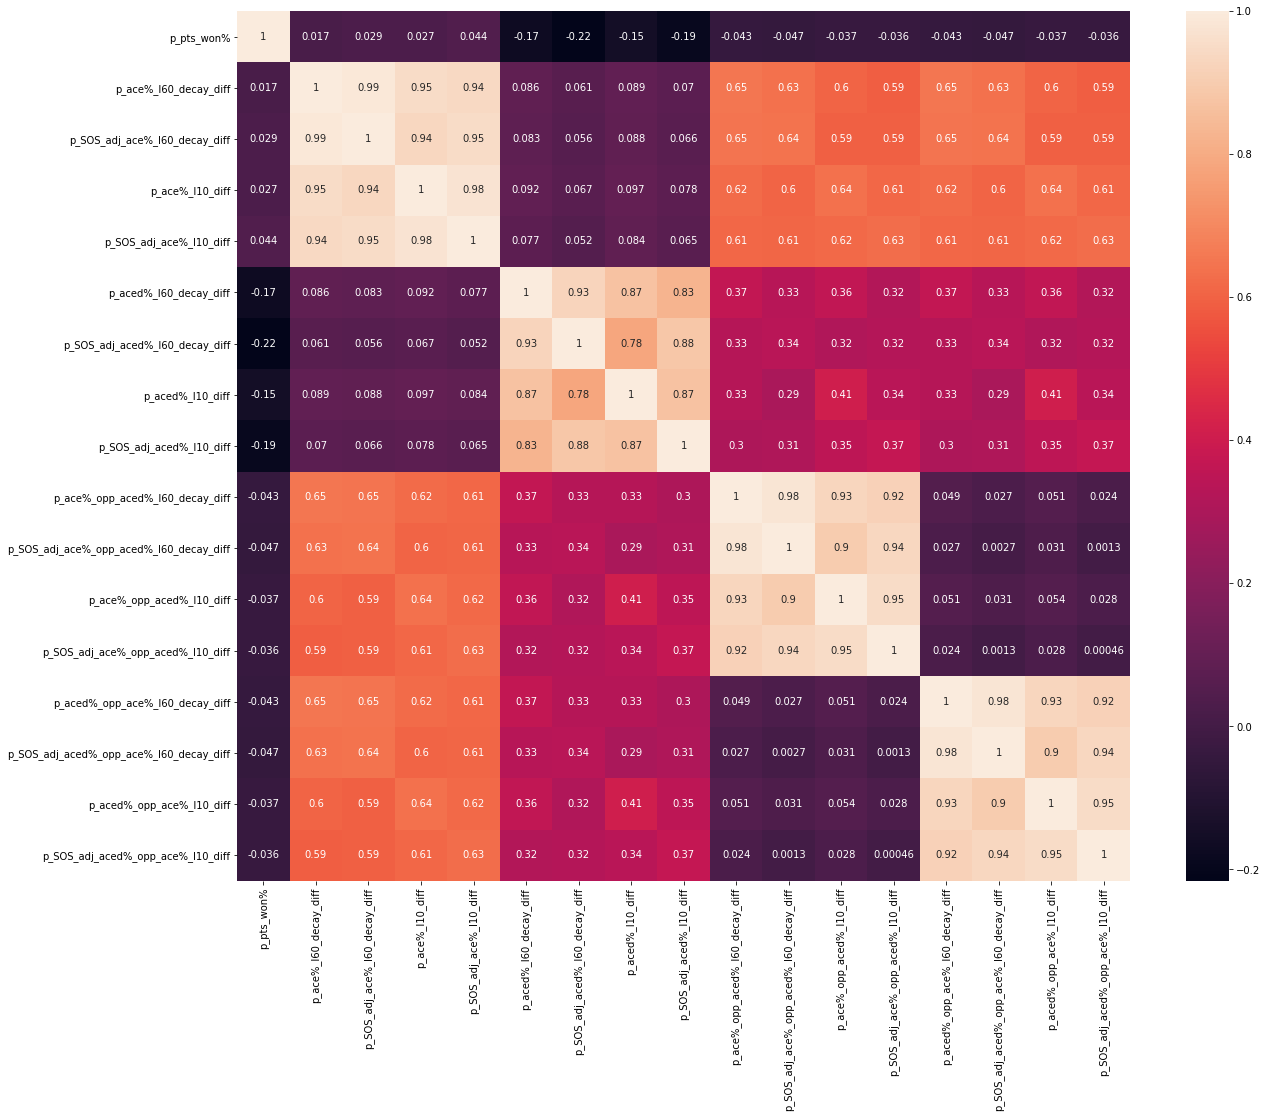

In [41]:
#Heatmap of correlations for pts_won% vs "differential features"
plt.subplots(figsize=(20,16))
sns.heatmap(df_filter_diff_3.corr(), annot = True);

Key Observations:
* This feature set deals just with ace and aced-related statistics. Not surprisingly, none of these features rises to the correlation levels of more aggregated "offense" or "defense" features.
* Still, it is interesting that there's a reatively large negative correlation (-0.22) betweeen player adjusted aced% differential over the last 60 surface-specific matches and pts won% in the match beg predicted on. Simply put, players with relatively high past ace suppression performance relative to their opponent (hence a negative differential value; see associated scatterplot below to help with this intuition) tend to win a higher percentage of points in the match being predicted on. There is some assymetry with ace%, suggesting that the ability to suppress aces from one' opponent relatively well is more correlated with future success on a hard court than being more successful than your opponent in the past in terms of serving aces to past opponents.  

### Stamina and Fatigue Stats-Related Correlations to % Points Won Per-Player Per-Match 

In [42]:
df_filter_diff_4 = df_filter3[["p_pts_won%", "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff"]]

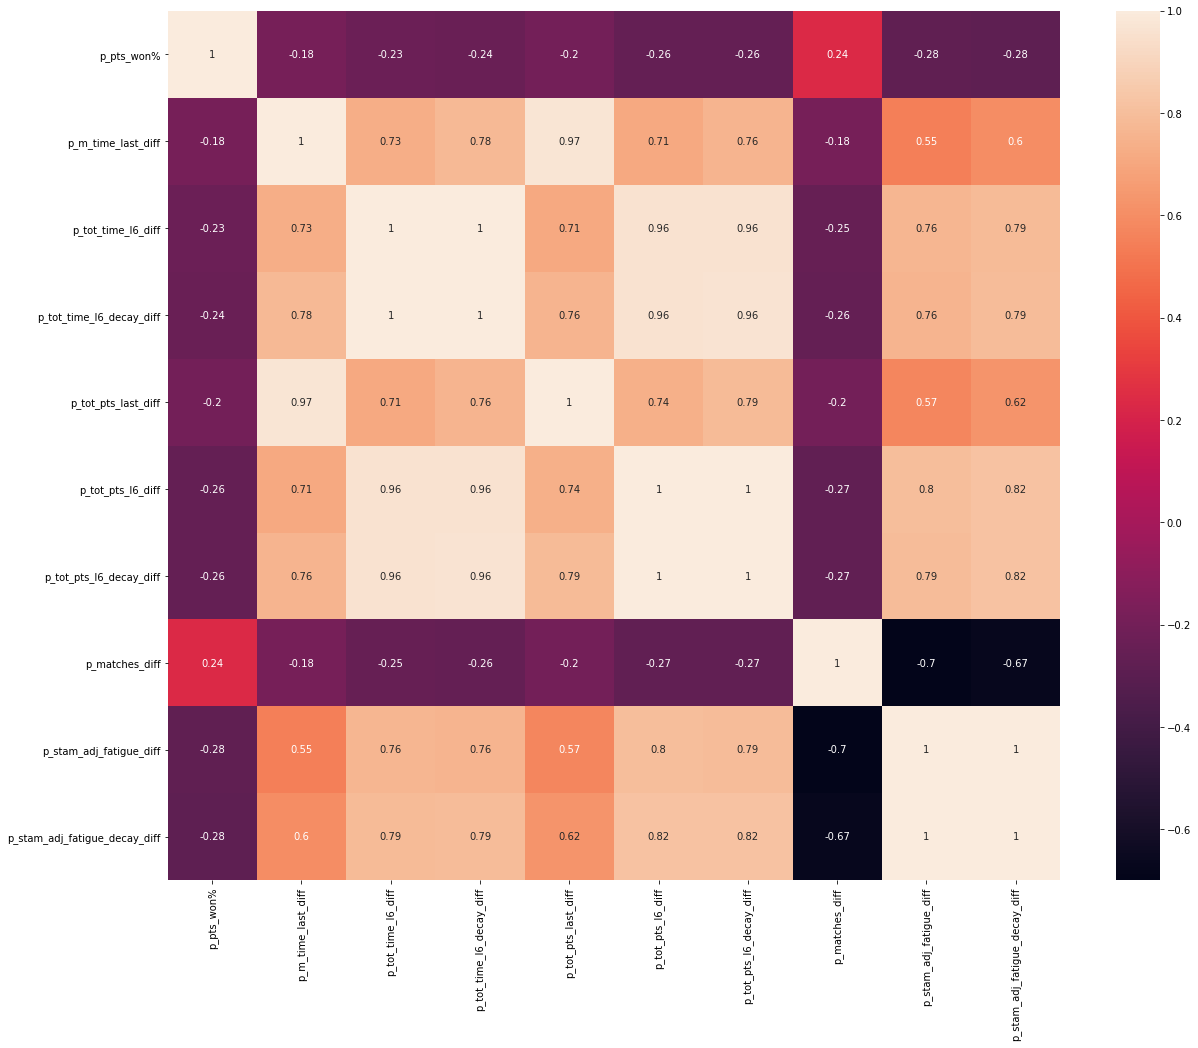

In [43]:
#Heatmap of correlations for pts_won% vs "differential features"
plt.subplots(figsize=(20,16))
sns.heatmap(df_filter_diff_4.corr(), annot = True);

#### Key Obervations: 

* Difference in number of past matches played has a reasonably strong positive correlation with the target feature of % pts won (0.24). This could be related both to survivorship bias (ie, strong players survive on tour long enough to play a lot of matches) and also to accrued stamina. ("p_matches_diff")
* To the latter point above, when player differences in time or points-based measures of fatigue (time or points accrued in all previous matches in a given tournamanent up to the maximum possible of 6; either decay weighted or no-decay weighted) are factored by the number of matches previously played by the players, there is a fairly strong correlation (-0.28) with the target feature of % total pts won by a given player in the match being predicted on. ("p_stam_adj_fatigue_diff")
    * The way this is calculated, a negative correlation favors a player with more past matches played in the overall sample over a player with fewer matches played in the overall sample given a scenario where the two players have played an equal amount of pts/time in the tournament up to their match versus each other. 
    * This could truly be because more matches played in the past = a "bigger battery" = more stamina, and/or because of survivorship bias (more past matches likely = higher relative skill vs the opponent with fewer matches). Perhaps bearing on relative contributions of the two components, model prediction quality feedback with adjustment of the impact of past match number ("battery size") has helped optimize this integrated feature (currently the fourth root of matches played is taken in the denominator; which performs slightly better predictively than taking the square or cube root). 
    * Past points played has a slightly higher correlation to the target feature than past minutes played, which makes sense given that pace of play is fairly variable from opponent to opponent (cough, Rafael Nadal, cough).   

### Scatterplots

In [44]:
### Let's look at some scatterplots of putatively predictive differential features vs the target feature of pts won%
def scatterplots(columns, ncol=None, figsize=(20, 40)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.8)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'p_pts_won%', data=df_filter_diff, alpha=0.5)
        ax.set(xlabel=col, ylabel='p_pts_won%')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

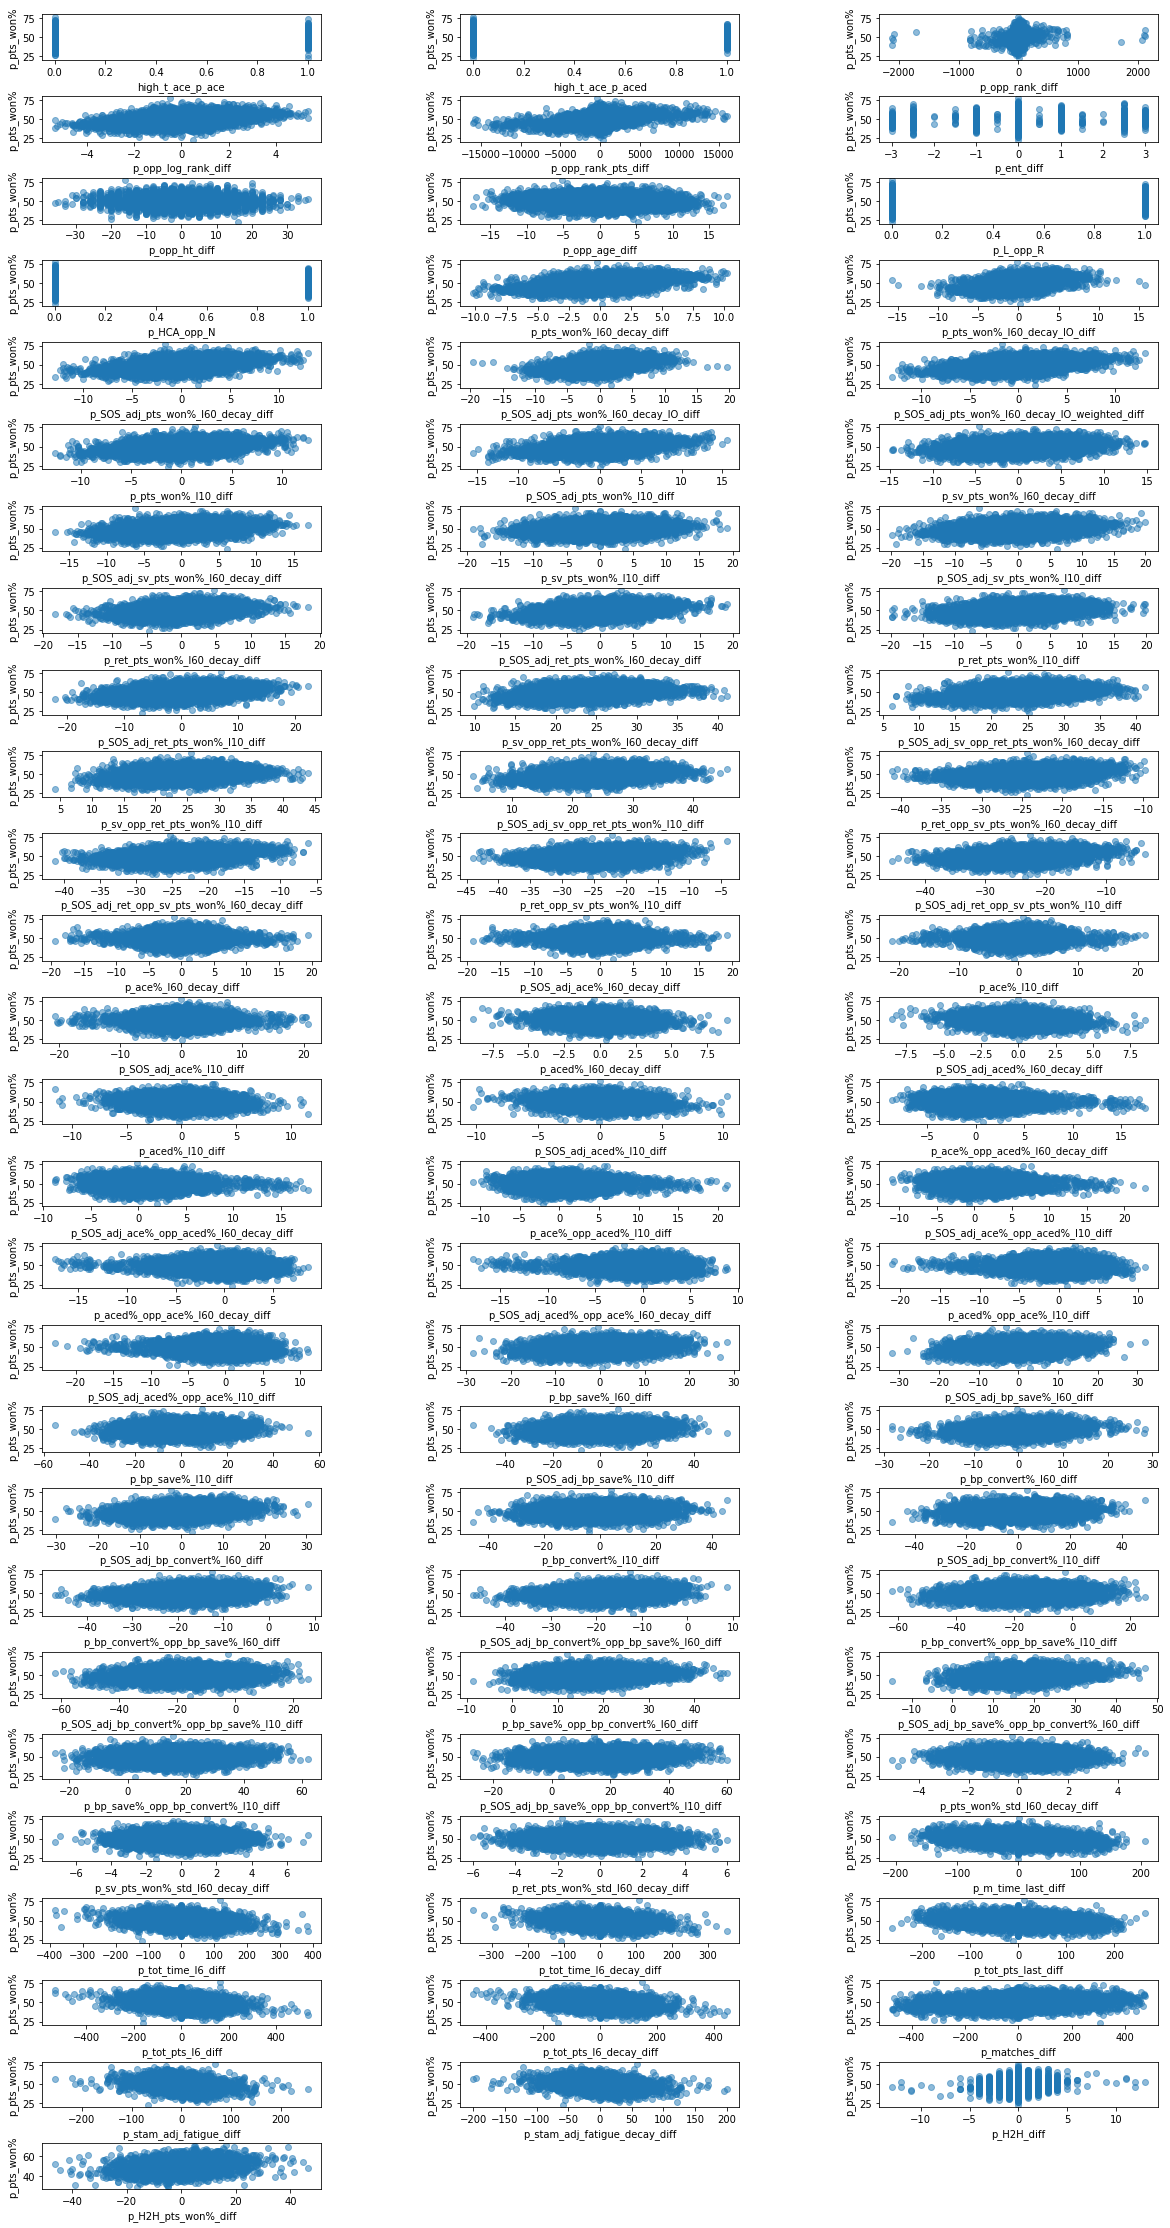

In [45]:
scatterplots(["high_t_ace_p_ace", "high_t_ace_p_aced", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l60_decay_diff", "p_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_diff", "p_SOS_adj_pts_won%_l60_decay_IO_diff", "p_SOS_adj_pts_won%_l60_decay_IO_weighted_diff", "p_pts_won%_l10_diff", "p_SOS_adj_pts_won%_l10_diff", "p_sv_pts_won%_l60_decay_diff", "p_SOS_adj_sv_pts_won%_l60_decay_diff", "p_sv_pts_won%_l10_diff", "p_SOS_adj_sv_pts_won%_l10_diff", "p_ret_pts_won%_l60_decay_diff", "p_SOS_adj_ret_pts_won%_l60_decay_diff", "p_ret_pts_won%_l10_diff", "p_SOS_adj_ret_pts_won%_l10_diff", "p_sv_opp_ret_pts_won%_l60_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff", "p_sv_opp_ret_pts_won%_l10_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l10_diff", "p_ret_opp_sv_pts_won%_l60_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff", "p_ret_opp_sv_pts_won%_l10_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l10_diff", "p_ace%_l60_decay_diff", "p_SOS_adj_ace%_l60_decay_diff", "p_ace%_l10_diff", "p_SOS_adj_ace%_l10_diff", "p_aced%_l60_decay_diff", "p_SOS_adj_aced%_l60_decay_diff", "p_aced%_l10_diff", "p_SOS_adj_aced%_l10_diff", "p_ace%_opp_aced%_l60_decay_diff", "p_SOS_adj_ace%_opp_aced%_l60_decay_diff", "p_ace%_opp_aced%_l10_diff", "p_SOS_adj_ace%_opp_aced%_l10_diff", "p_aced%_opp_ace%_l60_decay_diff", "p_SOS_adj_aced%_opp_ace%_l60_decay_diff", "p_aced%_opp_ace%_l10_diff", "p_SOS_adj_aced%_opp_ace%_l10_diff", "p_bp_save%_l60_diff", "p_SOS_adj_bp_save%_l60_diff", "p_bp_save%_l10_diff", "p_SOS_adj_bp_save%_l10_diff", "p_bp_convert%_l60_diff", "p_SOS_adj_bp_convert%_l60_diff", "p_bp_convert%_l10_diff", "p_SOS_adj_bp_convert%_l10_diff", "p_bp_convert%_opp_bp_save%_l60_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff", "p_bp_convert%_opp_bp_save%_l10_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l10_diff", "p_bp_save%_opp_bp_convert%_l60_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff", "p_bp_save%_opp_bp_convert%_l10_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l10_diff", "p_pts_won%_std_l60_decay_diff", "p_sv_pts_won%_std_l60_decay_diff", "p_ret_pts_won%_std_l60_decay_diff", "p_m_time_last_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_last_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "p_H2H_pts_won%_diff"], ncol=3)

Currently using the past year's ace% at the same tournament as a proxy for court speed in the current year. If we look at that measure vs player features in the current year (ie, in the matches being predicted on) can we see visual trends that may support this proxy?

In [46]:
df_ace_proxy_eval = df_filter[["t_ace%_last","p_sv_pts_won%", "p_ret_pts_won%", "p_ace%", "p_aced%","p_bp_save%","p_bp_convert%"]]

In [47]:
def scatterplots(columns, ncol=None, figsize=(10, 15)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.8)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = 't_ace%_last', y = col, data=df_ace_proxy_eval, alpha=0.5)
        ax.set(xlabel= 't_ace%_last', ylabel= col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

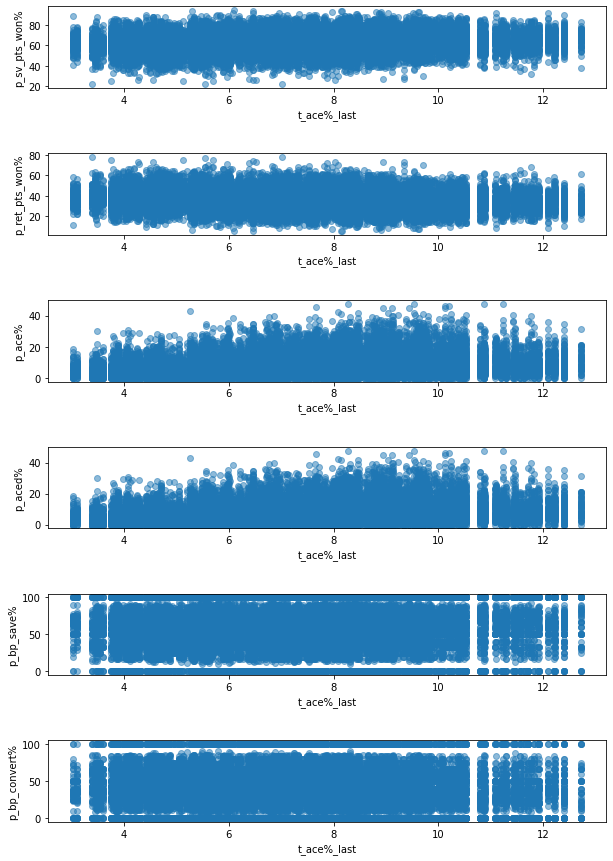

In [48]:
scatterplots(["p_sv_pts_won%", "p_ret_pts_won%", "p_ace%", "p_aced%","p_bp_save%","p_bp_convert%"], ncol=1)

can definitely see some upward trends in ace and aced% as last year's ace% increases. The tournies at the extreme highend of last year's aces are worth investigating. Conditions may change to counteract hatwhen it gets too out of hand. 